Using Power Divergence

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import power_divergence
import matplotlib.pyplot as plt
%matplotlib inline

Use LOO to remove unique value

In [2]:
def LeaveOneOut(data1, data2, columnName, useLOO=False):
    grpOutcomes = data1.groupby(columnName).mean().reset_index()
    outcomes = data2['outcome'].values
    x = pd.merge(data2[[columnName, 'outcome']], grpOutcomes,
                 suffixes=('x_', ''),
                 how='left',
                 on=columnName,
                 left_index=True)['outcome']
    if(useLOO):
        x = ((x*x.shape[0])-outcomes)/(x.shape[0]-1)
    return x.fillna(x.mean())

In [3]:
directory = '../input/'
train = pd.read_csv(directory+'act_train.csv')
people = pd.read_csv(directory+'people.csv')
train = pd.merge(train, people,
                 suffixes=('_train', '_people'),
                 how='left',
                 on='people_id',
                 left_index=True)
train.fillna('-999', inplace=True)
lootrain = pd.DataFrame()
for col in train.columns:
    if(col != 'outcome'):
        lootrain[col] = LeaveOneOut(train, train, col, True).values

In [4]:
lootrain['outcome'] = train['outcome'].values
lootrain.drop(['activity_id','people_id','group_1'], inplace=True, axis=1)


Use Power Divergence to grab the "best" parameters

In [5]:
features = lootrain.columns[:-1]
Y = lootrain.outcome.values.reshape(1,-1).T
Y = np.append(1 - Y, Y, axis=1)
observed = np.dot(Y.T, lootrain[features].values)
feature_count = lootrain[features].sum(axis=0).values.reshape(1,-1)
class_prob = Y.mean(axis=0).reshape(1,-1)
expected = np.dot(class_prob.T, feature_count)


In [6]:
stats, pvalues = power_divergence(observed, expected, ddof=0, axis=0, lambda_='log-likelihood')
best = features[stats.argsort()[-33:][::-1]]
best


Index(['char_38', 'char_2_people', 'char_8_people', 'char_9_people',
       'date_people', 'char_10_train', 'char_7_people', 'char_13', 'char_36',
       'char_34', 'char_6_people', 'char_37', 'char_25', 'char_17', 'char_22',
       'char_19', 'char_32', 'char_21', 'char_16', 'char_28', 'char_23',
       'char_20', 'char_10_people', 'char_15', 'char_31', 'char_14',
       'date_train', 'char_27', 'char_11', 'char_12', 'char_24',
       'char_3_people', 'char_35'],
      dtype='object')

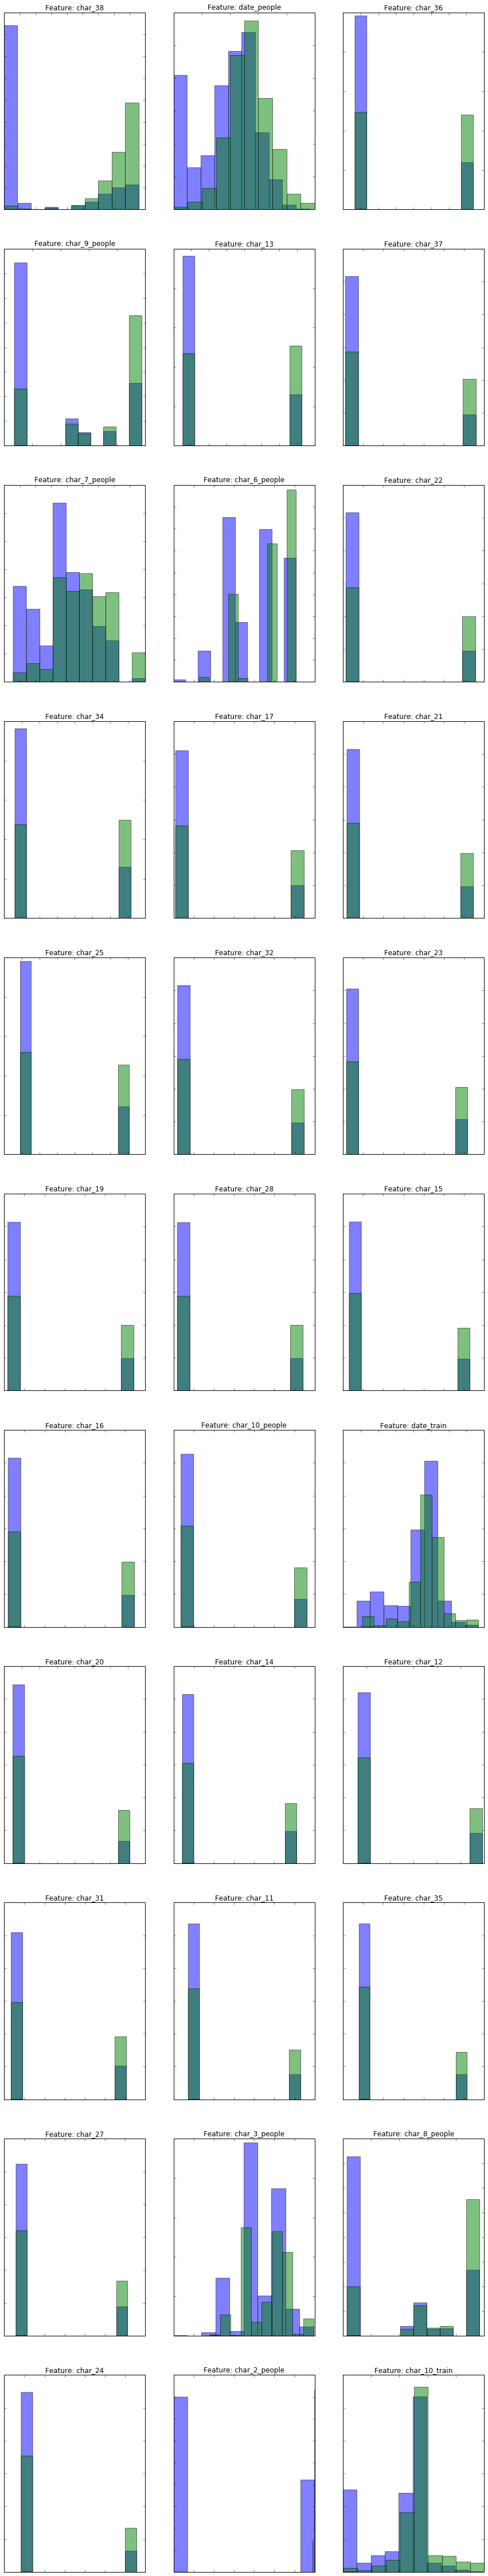

In [7]:
f, axarr = plt.subplots(11, 3, figsize=(15, 80))
index = 0
for i in best:
    tpl = (int(index/3)-index%3,index%3)
    axarr[tpl].hist(lootrain[lootrain.outcome==0][i],alpha=.5)
    axarr[tpl].hist(lootrain[lootrain.outcome==1][i],alpha=.5)
    axarr[tpl].set_title('Feature: '+i)
    axarr[tpl].set_xticklabels([])
    axarr[tpl].set_yticklabels([])
    index = index + 1
plt.show()

There are several lambdas to choose from just look at the documentation! ;)

Look at char_2_people - very interesting!!